In [1]:
!pip install natsort

In [2]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
import keras_cv
import pathlib
import natsort
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
import keras.backend as K
import random
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2025-02-13 18:28:58.948282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 18:28:58.948411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 18:28:59.089294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
Found GPU at: /device:GPU:0


In [3]:
epochs = 10000
batch = 16
imageShape = (512, 256, 1)
maskShape = (512, 256, 1)

In [4]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
    def readPathes(self,):
        self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
        self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
    def readImages(self, data, typeData):
        images = []
        for img in data:
            img = cv2.imread(str(img), 0)
            img = img/255
            img = cv2.resize(img, imageShape[:-1])
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)
    def dataAugmentation(self, images, masks):
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
            for aug in range(2):
                imageup = image
                maskup = mask
                if aug == 0:
                    imageup = image
                    maskup = mask
                else:
                    imageup = tf.image.flip_left_right(imageup)
                    maskup = tf.image.flip_left_right(maskup)
                imagesupdate.append(imageup), masksupdate.append(maskup)
        return np.array(imagesupdate), np.array(masksupdate)

# Children dataset

In [7]:
train_set_1 = readDataset('/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Train/images',
                            '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Train/mask')
train_set_1.readPathes()

train_set_2 = readDataset('/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Supplemental content93/images',
                            '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Supplemental content93/mask')
train_set_2.readPathes()

test_set = readDataset('/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/images',
                        '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/mask')
test_set.readPathes()


train_images_1 = train_set_1.readImages(train_set_1.images, 'i')
train_masks_1 = train_set_1.readImages(train_set_1.masks, 'm')

train_images_2 = train_set_2.readImages(train_set_2.images, 'i')
train_masks_2 = train_set_2.readImages(train_set_2.masks, 'm')

test_images = test_set.readImages(test_set.images, 'i')
test_masks = test_set.readImages(test_set.masks, 'm')

train_images_1.shape, train_masks_1.shape,train_images_2.shape, train_masks_2.shape,test_images.shape, test_masks.shape,


validImages = test_images
validMasks = test_masks
trainImages = np.concatenate((train_images_1, train_images_2), axis=0)
trainMasks = np.concatenate((train_masks_1, train_masks_2), axis=0)

trainImages = np.expand_dims(trainImages, axis=-1)
trainMasks = np.expand_dims(trainMasks, axis=-1)

validImages = np.expand_dims(validImages, axis=-1)
validMasks = np.expand_dims(validMasks, axis=-1)

trainImages.shape, trainMasks.shape,validImages.shape, validMasks.shape

((163, 256, 512, 1), (163, 256, 512, 1), (30, 256, 512, 1), (30, 256, 512, 1))

# Adult Dataset

In [5]:
train_set = readDataset('/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images',
                            '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks')
train_set.readPathes()

test_set = readDataset('/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images',
                        '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks')
test_set.readPathes()

test_set.images = test_set.images[100:376]
test_set.masks = test_set.masks[100:376]

train_set.images = train_set.images[:1500]
train_set.masks = train_set.masks[:1500]

train_images= train_set.readImages(train_set.images, 'i')
train_masks = train_set.readImages(train_set.masks, 'm')

test_images = test_set.readImages(test_set.images, 'i')
test_masks = test_set.readImages(test_set.masks, 'm')


validImages = test_images
validMasks = test_masks
trainImages = train_images
trainMasks = train_masks

trainImages = np.expand_dims(trainImages, axis=-1)
trainMasks = np.expand_dims(trainMasks, axis=-1)

validImages = np.expand_dims(validImages, axis=-1)
validMasks = np.expand_dims(validMasks, axis=-1)

trainImages.shape, trainMasks.shape,validImages.shape, validMasks.shape

((1500, 256, 512, 1),
 (1500, 256, 512, 1),
 (276, 256, 512, 1),
 (276, 256, 512, 1))

In [6]:
trainImages.shape, trainMasks.shape,validImages.shape, validMasks.shape

((1500, 256, 512, 1),
 (1500, 256, 512, 1),
 (276, 256, 512, 1),
 (276, 256, 512, 1))

In [7]:
import numpy as np

# Assuming trainImages, trainMasks, validImages, and validMasks are already defined

# Get the number of samples
num_samples = trainImages.shape[0]

# Generate shuffled indices
shuffled_indices = np.random.permutation(num_samples)

# Apply shuffled indices to all arrays
trainImages = trainImages[shuffled_indices]
trainMasks = trainMasks[shuffled_indices]

# Repeat the process for validImages and validMasks
num_valid_samples = validImages.shape[0]
shuffled_indices_valid = np.random.permutation(num_valid_samples)
validImages = validImages[shuffled_indices_valid]
validMasks = validMasks[shuffled_indices_valid]

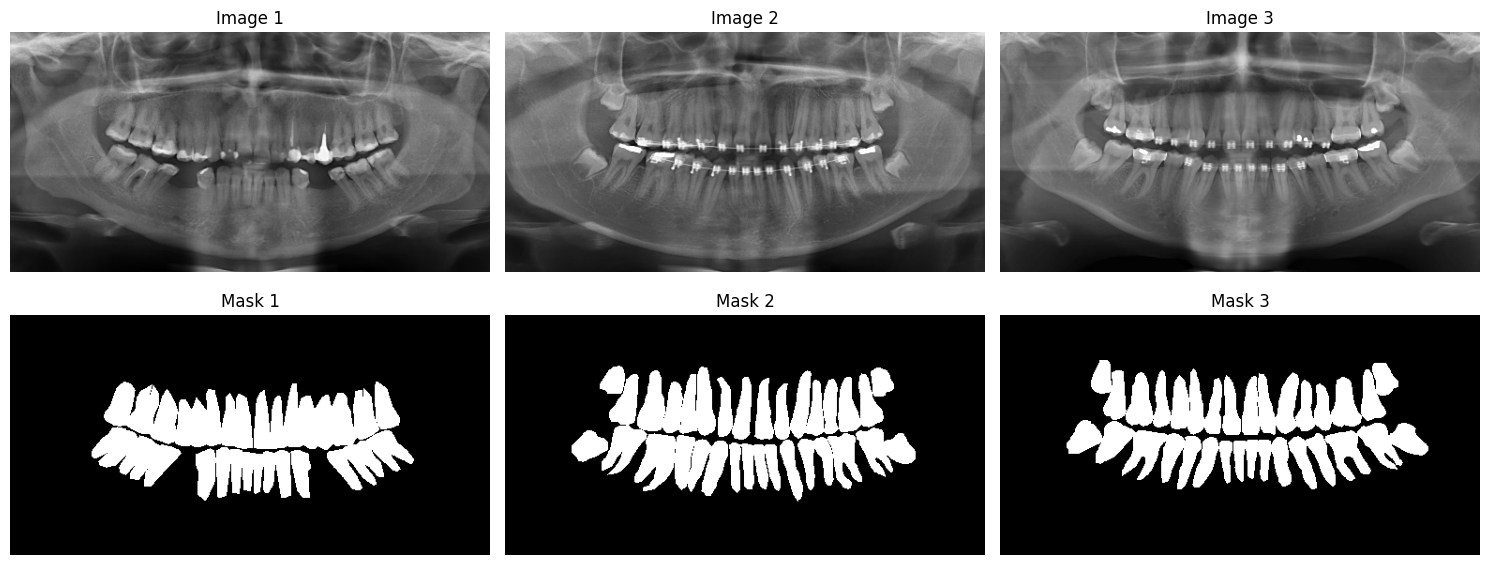

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15,6))
offset = 200
for i in range(3):
    axes[0, i].imshow(trainImages[i+offset], cmap = 'gray')
    axes[0, i].set_title(f'Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(trainMasks[i+offset], cmap='gray')
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

In [10]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Define custom loss and metrics functions

def iou(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def recall(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + K.epsilon())
	return recall

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    true_negatives = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32), axis=[1,2,3])
    possible_negatives = tf.reduce_sum(tf.cast(1 - y_true, tf.float32), axis=[1,2,3])
    specificity = tf.reduce_mean(true_negatives / (possible_negatives + K.epsilon()), axis=0)
    return specificity

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)), axis=[1,2,3])
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)), axis=[1,2,3])
    precision = tf.reduce_mean(true_positives / (predicted_positives + K.epsilon()), axis=0)
    return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def log_coshx_dice_loss(y_true, y_pred):
    return K.log(tf.math.cosh(dice_loss(y_true, y_pred)))


In [11]:
from tensorflow.keras import layers

def ghost_module(inputs, drop_rate=0.3, block_size=7):
    conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    conv2 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(act1)
    return concatenate([act1, conv2], axis = 3)

def simple_conv2d(inputs, drop_rate=0.3, block_size=7):
    conv1 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    return act1

def scf_block(input_tensor, filters=512, rates=[1, 3, 5]):
    branches = []
    for rate in rates:
        branch = Conv2D(filters, (3, 3), padding='same', dilation_rate=rate, name="dilated_conv"+str(rate))(input_tensor)
        branch = tf.nn.relu(branch)
        branches.append(branch)
    output = Add()(branches)
    return output

def lcat_net(input_shape = (256, 512, 1)):

    inputs = Input(shape=input_shape, name="image")
    x1 = simple_conv2d(simple_conv2d(inputs)) # 256x512x128
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x2 = simple_conv2d(simple_conv2d(pool1)) # 128x256x128
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = simple_conv2d(simple_conv2d(pool2)) # 64x128x128
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x4 = simple_conv2d(simple_conv2d(pool3)) # 32x64x128
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x5 = ghost_module(ghost_module(pool4)) # 16x32x128
    


    # Dense skip connections (Prepare sizes using MaxPlooings)
    down1to2 = MaxPooling2D(pool_size=(2, 2))(x1)
    down1to3 = MaxPooling2D(pool_size=(4, 4))(x1)
    down1to4 = MaxPooling2D(pool_size=(8, 8))(x1)
    down1to5 = MaxPooling2D(pool_size=(16, 16))(x1)

    down2to3 = MaxPooling2D(pool_size=(2, 2))(x2)
    down2to4 = MaxPooling2D(pool_size=(4, 4))(x2)
    down2to5 = MaxPooling2D(pool_size=(8, 8))(x2)


    down3to4 = MaxPooling2D(pool_size=(2, 2))(x3)
    down3to5 = MaxPooling2D(pool_size=(4, 4))(x3)
    
    down4to5 = MaxPooling2D(pool_size=(2, 2))(x4)
    down4to6 = MaxPooling2D(pool_size=(4, 4))(x4)
    
    # CBAMs
    cbam1 = cbam(x1) # CBAM_1
    cbam2 = cbam(Add()([x2,down1to2]))  # CBAM_2(DSM_1)
    cbam3 = cbam(Add()([x3,down1to3, down2to3]))  # CBAM_3(DSM_2)
    cbam4 = cbam(Add()([x4,down1to4, down2to4, down3to4])) # CBAM_4(DSM_3)
    cbam5 = cbam(Add()([x5,down1to5, down2to5, down3to5, down4to5])) # CBAM_4(DSM_4)

    # Upsamplings
    cbam2 = UpSampling2D(size = (2,2))(cbam2)
    cbam3 = UpSampling2D(size = (4,4))(cbam3)
    cbam4 = UpSampling2D(size = (8,8))(cbam4)
    cbam5 = UpSampling2D(size = (16,16))(cbam5)

    # MCF module
    rates = [1, 3, 5, 7] 
    scf = scf_block(x5, filters=128, rates=rates)
    mcf = Add()([cbam(scf), x5])
    mcf =  UpSampling2D(size = (16,16))(mcf)
    
    upScaled = Add()([cbam1, cbam2, cbam3, cbam4, cbam5, mcf])    

    all_conv = simple_conv2d(simple_conv2d(upScaled))
    final_conv = Conv2D(1, 1, activation = 'sigmoid')(all_conv)
    half_unet_model = tf.keras.Model(inputs, final_conv, name="Half-UNet")
    return half_unet_model

In [12]:
!rm -f /kaggle/working/*

rm: cannot remove '/kaggle/working/Keras_FLOP_Estimator': Is a directory


In [14]:
model = lcat_net((256, 512, 1))

In [17]:
from tensorflow.keras.callbacks import Callback
import numpy as np
import os

class StdCallback(Callback):
    def __init__(self, file_name=None):
        super().__init__()
        self.file_name = file_name
        if file_name:
            with open(file_name, 'w') as f:
                f.write("Epoch, Metric, Std\n")  # Write the header for the CSV file

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        results = []
        for metric in logs:
            if metric!= 'loss' and 'val_' not in metric:  # Skip validation metrics
                metric_values = self.model.history.history[metric]
                std_value = np.std(metric_values)
                result = f"Epoch {epoch + 1}: {metric} std = {std_value}"
                print(result)
                results.append(f"{epoch + 1}, {metric}, {std_value}\n")
        if self.file_name:
            with open(self.file_name, 'a') as f:
                f.writelines(results)

In [ ]:
from tensorflow import keras

print("===================== LCAT_NET ====================")
# model = lcat_net((256, 512, 1))
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy', iou, F1, recall, specificity, precision, dice_coef])
callbacks = [
    keras.callbacks.ModelCheckpoint("/kaggle/working/LCAT-Net.keras", save_best_only=True)
]
history_lcat_net = model.fit(
    trainImages[:500], 
    trainMasks[:500], 
    epochs=100, 
    batch_size=6, 
    validation_data=(validImages[:100], validMasks[:100]),  # Replace with validation_split if needed
    callbacks=callbacks
)

===================== LCAT_NET ====================
Epoch 1/100


I0000 00:00:1739471790.181888     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 [==============================] - 63s 506ms/step - loss: 0.1839 - accuracy: 0.9288 - iou: 0.7201 - F1: 0.8289 - recall: 0.8413 - specificity: 0.9517 - precision: 0.8377 - dice_coef: 0.8383 - val_loss: 0.3000 - val_accuracy: 0.8727 - val_iou: 0.6113 - val_F1: 0.7570 - val_recall: 0.9251 - val_specificity: 0.8579 - val_precision: 0.6444 - val_dice_coef: 0.7581
Epoch 2/100
84/84 [==============================] - 37s 442ms/step - loss: 0.1039 - accuracy: 0.9581 - iou: 0.8055 - F1: 0.8911 - recall: 0.8874 - specificity: 0.9763 - precision: 0.9035 - dice_coef: 0.8955 - val_loss: 0.2608 - val_accuracy: 0.8948 - val_iou: 0.5531 - val_F1: 0.7082 - val_recall: 0.6004 - val_specificity: 0.9772 - val_precision: 0.8827 - val_dice_coef: 0.7110
Epoch 3/100
84/84 [==============================] - 36s 431ms/step - loss: 0.0920 - accuracy: 0.9627 - iou: 0.8262 - F1: 0.9038 - recall: 0.9008 - specificity: 0.9786 - precision: 0.9134 - dice_coef: 0.9068 - val_loss: 0.4493 - val_accuracy: 0.8379 - 

In [21]:
# Load Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Step 1: Load the checkpointed model
checkpoint_path = '/kaggle/working/LCAT-Net.keras'
model = load_model(checkpoint_path, custom_objects={"iou": iou ,"F1": F1, "recall": recall, "specificity": specificity, "precision":precision, "dice_coef": dice_coef})

In [22]:
import numpy as np

#load the model
# model = load_model('/kaggle/working/lcat_net_children.keras', custom_objects={"iou": iou ,"F1": F1, "recall": recall, "precision": precision, "dice_coef": dice_coef})

# Set batch size
batch_size = 4

# Evaluate the model on the test data in batches
num_samples = len(validImages[100])
num_batches = (num_samples + batch_size - 1) // batch_size  # Calculate number of batches
all_metrics_values = []

for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, num_samples)
    images_batch = validImages[start_index:end_index]
    masks_batch = validMasks[start_index:end_index]
    
    # Evaluate the model on the batch
    loss, *metrics_values = model.evaluate(images_batch, masks_batch, verbose=0)
    all_metrics_values.append(metrics_values)

# Calculate mean and standard deviation of each metric across batches
mean_metrics = np.mean(all_metrics_values, axis=0)
std_metrics = np.std(all_metrics_values, axis=0)

# Print mean and standard deviation of each metric
print("Mean loss:", loss)
for i, metric_value in enumerate(mean_metrics):
    print(f"Mean {model.metrics_names[i+1]}:", metric_value)
    print(f"Standard deviation of {model.metrics_names[i+1]}:", std_metrics[i])


Mean loss: 0.0692363828420639
Mean accuracy: 0.9706461131572723
Standard deviation of accuracy: 0.0033043725840255817
Mean iou: 0.8744844915345311
Standard deviation of iou: 0.013904589921275216
Mean F1: 0.9327013213187456
Standard deviation of F1: 0.007993074824884904
Mean recall: 0.9516597790643573
Standard deviation of recall: 0.013661148202800467
Mean specificity: 0.9763060007244349
Standard deviation of specificity: 0.006510896817541244
Mean precision: 0.9162039030343294
Standard deviation of precision: 0.02327137225037171
Mean dice_coef: 0.9333159597590566
Standard deviation of dice_coef: 0.007656577444151761


In [23]:
import pickle
from keras.callbacks import History

def dict_to_history(history_dict):
    history = History()
    history.history = history_dict
    return history

def save_model_and_history(model, history, model_filename, history_filename):
    # Save the model
    model.save(model_filename)
    
    # Save the history
    with open(history_filename, 'wb') as file:
        pickle.dump(history.history, file)

def load_model_and_history(model_filename, history_filename):
    from keras.models import load_model
#     ['accuracy', iou, F1, recall, specificity, precision, dice_coef]
    # Load the model
    model = load_model(model_filename, custom_objects={"iou": iou ,"F1": F1, "recall": recall, "specificity": specificity, "precision":precision, "dice_coef": dice_coef})
    
    # Load the history
    with open(history_filename, 'rb') as file:
        history = pickle.load(file)
    
    return model, dict_to_history(history)

In [24]:
save_model_and_history(model, history_lcat_net, '/kaggle/working/lcat_net.h5', '/kaggle/working/lcat_net_history.pkl')


In [26]:
model, history_lcat_net = load_model_and_history('/kaggle/working/lcat_net.h5', '/kaggle/working/lcat_net_history.pkl')

1/1 [==============================] - 5s 5s/step


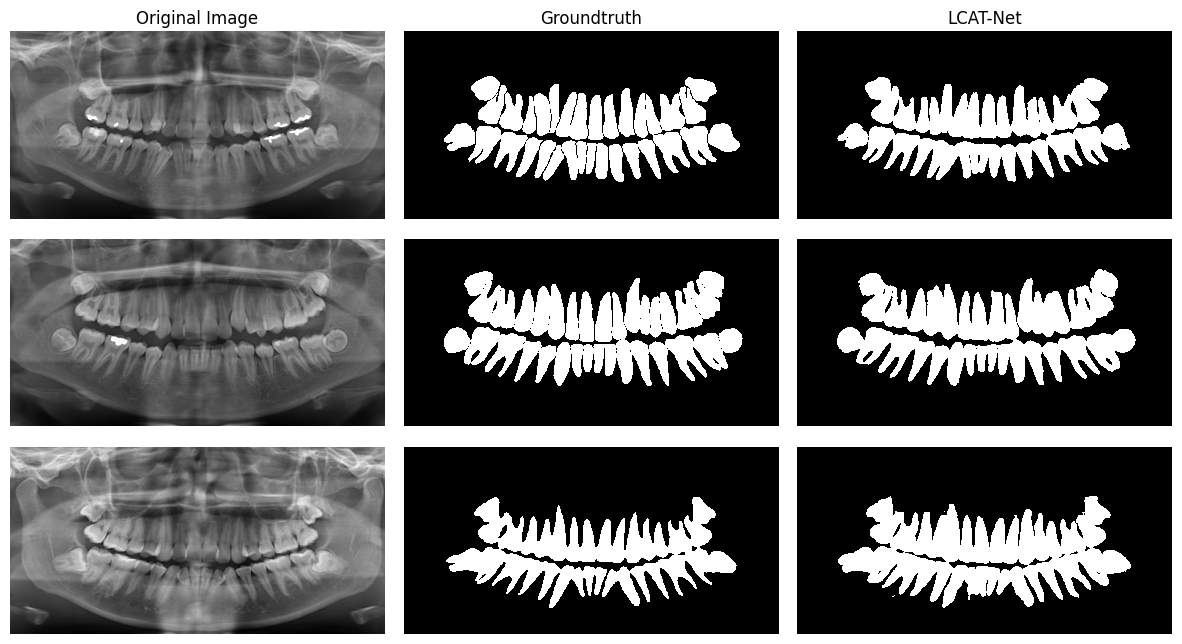

In [27]:
   
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming model is defined and validImages, validMasks are your datasets.

# Predictions might be probabilities or raw scores, convert them to binary (0 or 1)
predictions = model.predict(validImages[:10])

# Define a custom color map: black, white, red, blue
white_or_black_cmap = mcolors.ListedColormap(['black', 'white'])

# Create a new figure and set its size
plt.figure(figsize=(15, 45))

for i in range(3):
    # Plotting the results
    plt.subplot(10, 3, i * 3 + 1)
    plt.imshow(validImages[i], cmap='gray')
    if i == 0:
        plt.title('Original Image')
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 2)
    plt.imshow(validMasks[i], cmap=white_or_black_cmap)
    if i == 0:
        plt.title('Groundtruth')
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 3)
    plt.imshow(predictions[i], cmap=white_or_black_cmap)
    if i == 0:
        plt.title('LCAT-Net')
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.05, hspace=-0.87)
plt.savefig(f"/kaggle/working/lcat_net_children_results.png", dpi=200, bbox_inches='tight', pad_inches=0)  # Save each figure with specified settings
plt.show()


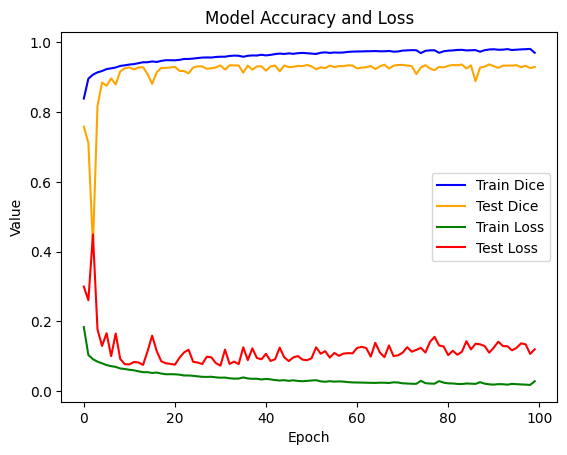

In [30]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot accuracy and loss in the same plot with different colors
    plt.plot(history.history['dice_coef'], color='blue', label='Train Dice')
    plt.plot(history.history['val_dice_coef'], color='orange', label='Test Dice')
    plt.plot(history.history['loss'], color='green', label='Train Loss')
    plt.plot(history.history['val_loss'], color='red', label='Test Loss')

    plt.title('Model Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
plot_history(history_lcat_net)